In [2]:
"""
Time Series Analysis
"""
# importing libraries used in the analysis

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import ExcelWriter

DatetimeIndex(['2018-03-11 20:00:00', '2018-03-11 21:00:00',
               '2018-03-11 22:00:00', '2018-03-11 23:00:00',
               '2018-03-12 00:00:00', '2018-03-12 01:00:00',
               '2018-03-12 02:00:00', '2018-03-12 03:00:00',
               '2018-03-12 04:00:00', '2018-03-12 05:00:00',
               ...
               '2018-04-10 23:00:00', '2018-04-11 00:00:00',
               '2018-04-11 01:00:00', '2018-04-11 02:00:00',
               '2018-04-11 03:00:00', '2018-04-11 04:00:00',
               '2018-04-11 05:00:00', '2018-04-11 06:00:00',
               '2018-04-11 07:00:00', '2018-04-11 08:00:00'],
              dtype='datetime64[ns]', name='Date', length=733, freq='H')


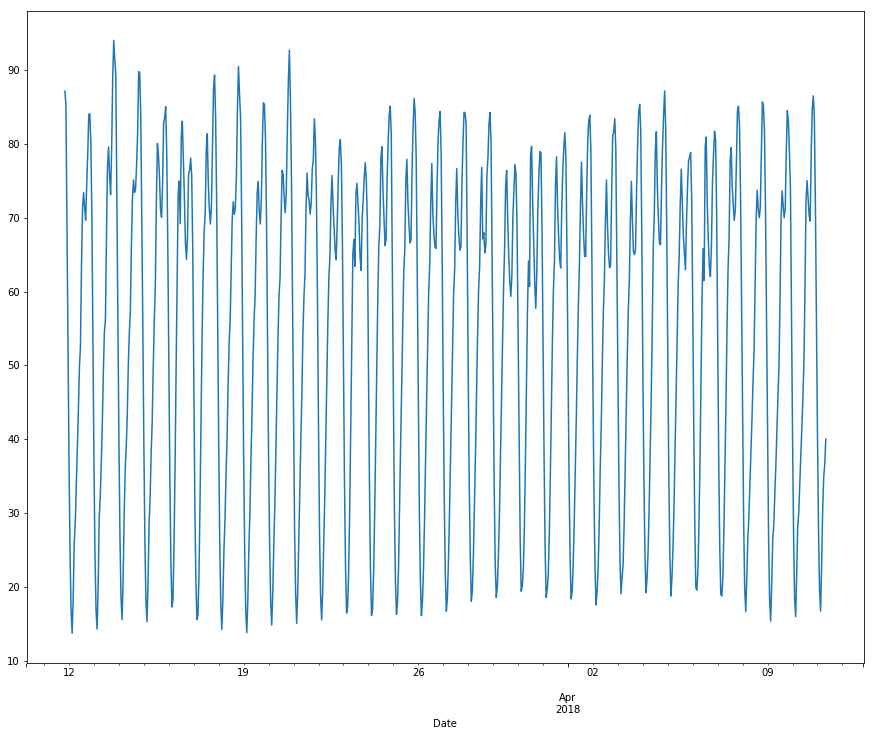

In [3]:
# plotting time series
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')
df = pd.read_excel('D:\DataScience\DevInst\Total Internet Traffic-2018_11_6_4_27_10.xlsx', 
                   parse_dates=True, index_col='Date',date_parser=dateparse)
ip_data = df['Value'].str.replace(" Gbps", "")
ip_data=pd.to_numeric(ip_data)
ip_data = ip_data.resample('H').mean() #15T
ip_data = ip_data.interpolate(method='linear')
print(ip_data.index)
ip_data.plot(figsize=(15, 12))
plt.show()


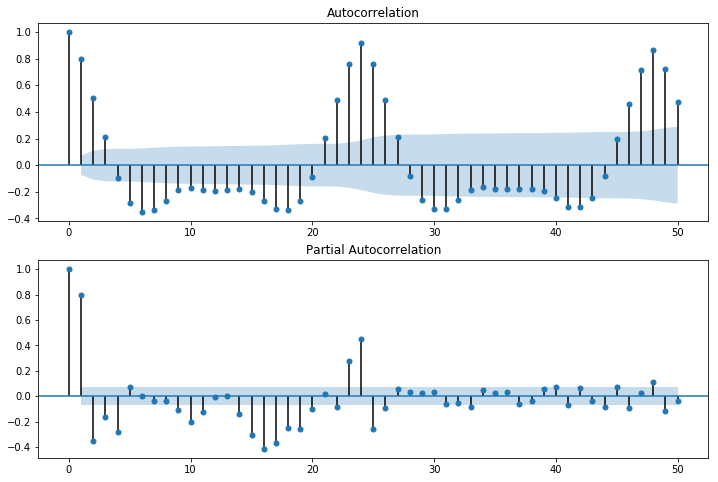

In [4]:
# plotting ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ip_data.diff().dropna(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ip_data.diff().dropna(), lags=50, ax=ax2)
plt.show()

In [5]:
#Perform Dickey-Fuller test:
stationary_result = adfuller(ip_data)
print('ADF Statistic: %f' % stationary_result[0])
print('p-value: %f' % stationary_result[1])
print('Critical Values:')
for key, value in stationary_result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.956959
p-value: 0.000027
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


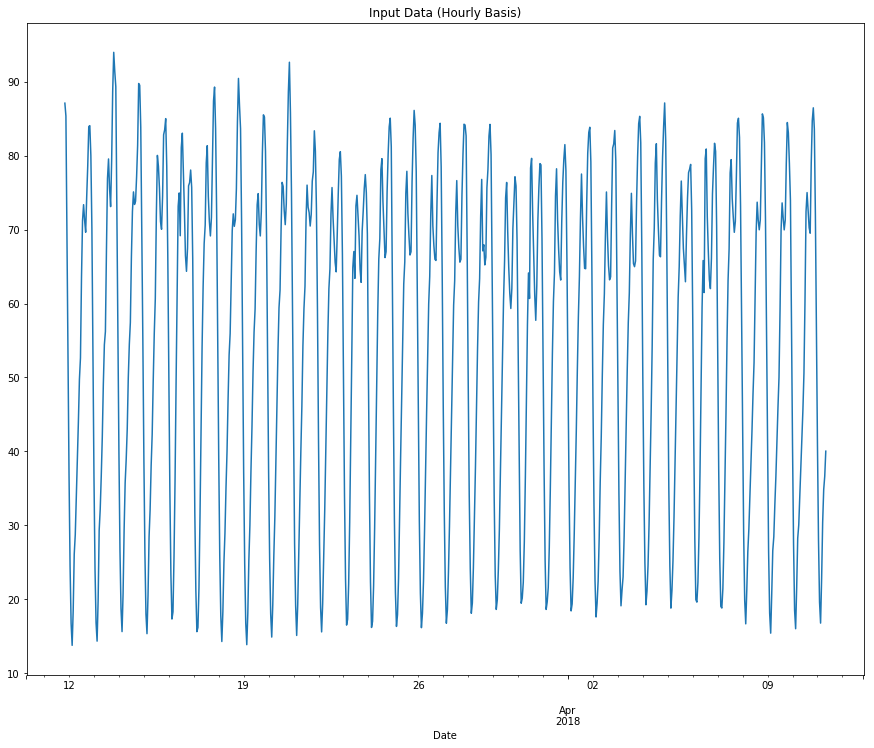

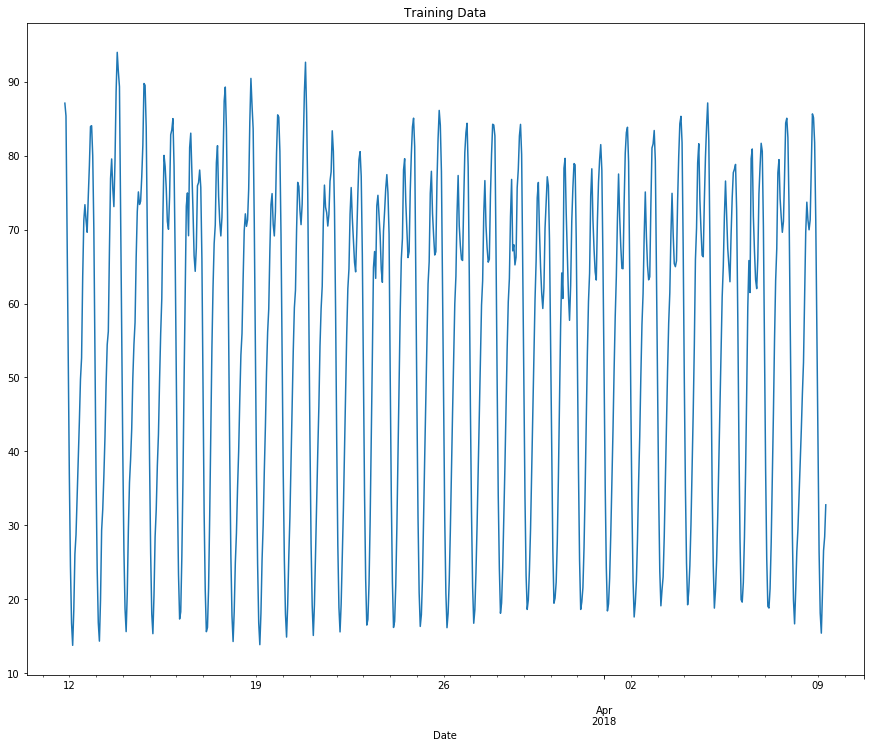

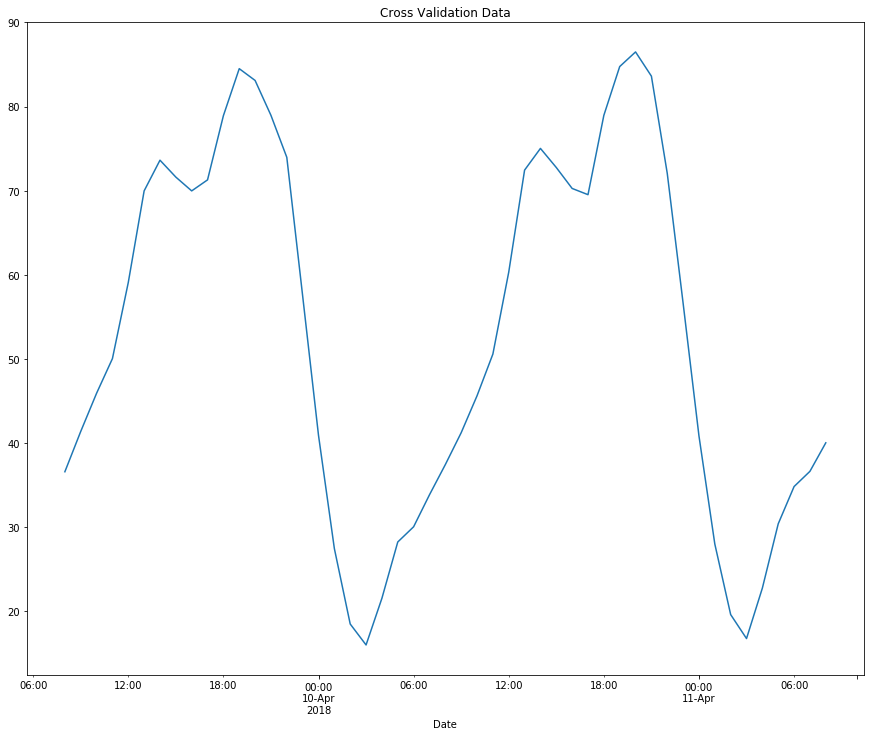

In [6]:
# Splitting imported data to training and cross validation
split_point = round(len(ip_data)*672/720)
ip_data.plot(figsize=(15, 12))
plt.title('Input Data (Hourly Basis)')
plt.show()
training, cv = ip_data[0:split_point], ip_data[split_point:]
training.plot(figsize=(15, 12))
plt.title('Training Data')
plt.show()
cv.plot(figsize=(15, 12))
plt.title('Cross Validation Data')
plt.show()


In [7]:
#Decomposition
#decomposition = seasonal_decompose(df['Value'], model='additive', freq=24)  
#fig = plt.figure()
#fig = decomposition.plot()  
#fig.set_size_inches(15, 8)
#trend = decomposition.trend
#seasonal = decomposition.seasonal 
#residual = decomposition.residual 

                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  684
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 24)   Log Likelihood               -1265.335
Date:                            Tue, 12 Jun 2018   AIC                           2548.670
Time:                                    15:13:02   BIC                           2589.421
Sample:                                03-11-2018   HQIC                          2564.440
                                     - 04-09-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3468      0.144      9.374      0.000       1.065       1.628
ar.L2         -0.4465      0.181   

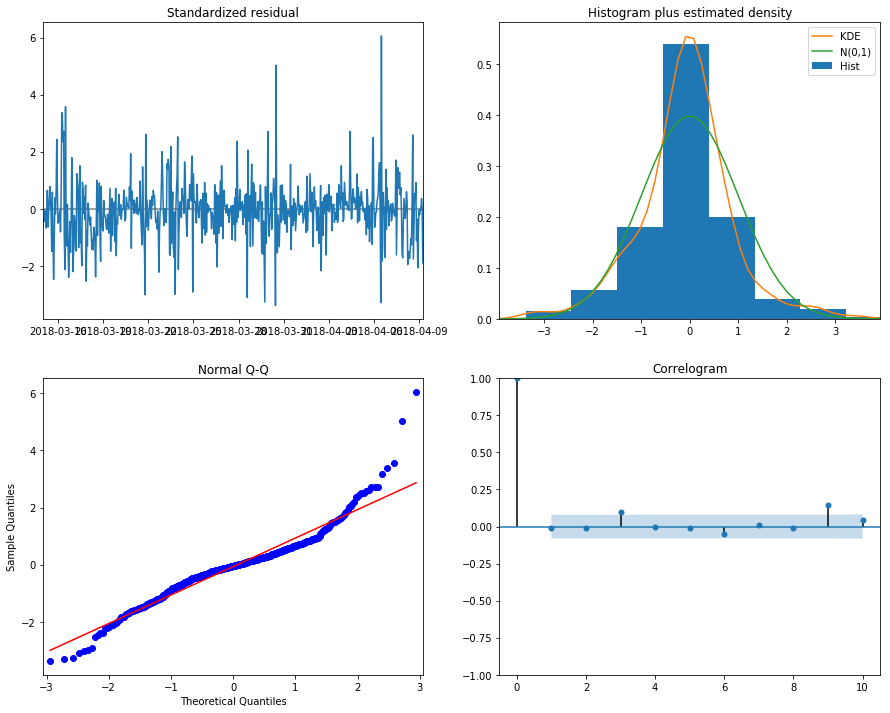

In [8]:
# Training the Model
warnings.filterwarnings("ignore") # specify to ignore warning messages  
#SARIMA Model order=(2,0,2), seasonal_order=(0,1,1,24)
mod = sm.tsa.statespace.SARIMAX(training, order=(3,1,2), seasonal_order=(1,1,2,24),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()
print(results.summary())
# Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

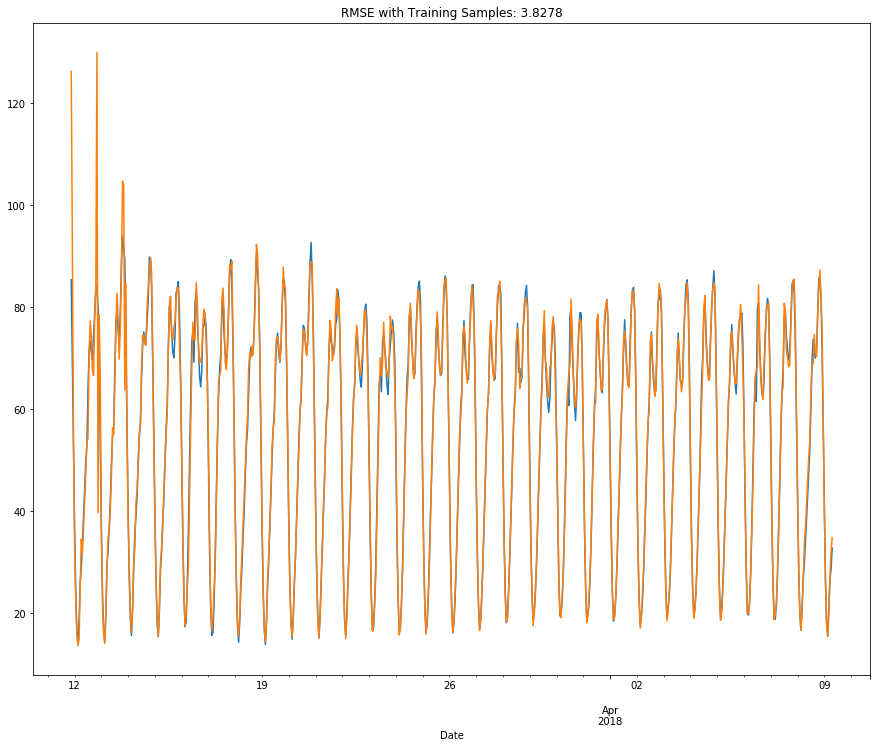

In [9]:
# Predict Vs. Training (2/3 from the i/p data)
predict_data = results.fittedvalues 
rmse_train=np.sqrt(sum((predict_data[1:]-training[1:])**2)/len(training[1:]))
training[1:].plot(figsize=(15, 12))
predict_data[1:].plot(figsize=(15, 12))
plt.title('RMSE with Training Samples: %.4f'% rmse_train)
plt.show()

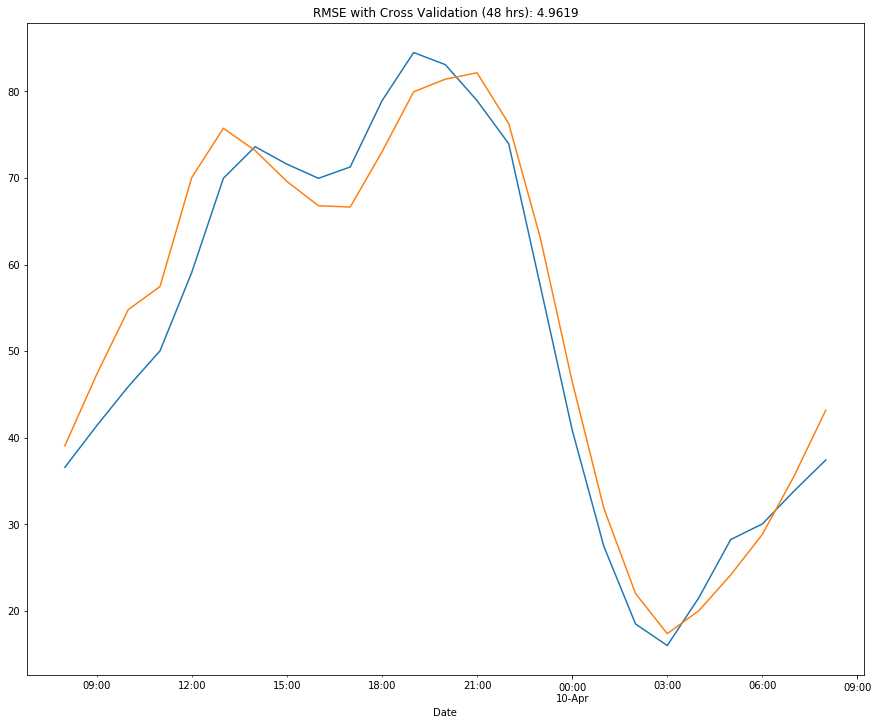

In [10]:
# Forecast Vs. Cross Validation (48 hours after training data)
Future_step = 24*1
forecast_start_point1 = ip_data.index[split_point-1].strftime('%m/%d/%Y %I:%M:%S %p')
forecast_end_point1 = ip_data.index[split_point+Future_step].strftime('%m/%d/%Y %I:%M:%S %p')
forecast_data1= results.predict(start=forecast_start_point1, end=forecast_end_point1)
rmse_cv2=np.sqrt(sum((forecast_data1[1:]-cv[0:Future_step+1])**2)/Future_step)
cv[0:Future_step+1].plot(figsize=(15, 12))
forecast_data1[1:].plot(figsize=(15, 12))
plt.title('RMSE with Cross Validation (48 hrs): %.4f'% rmse_cv2)
plt.show()


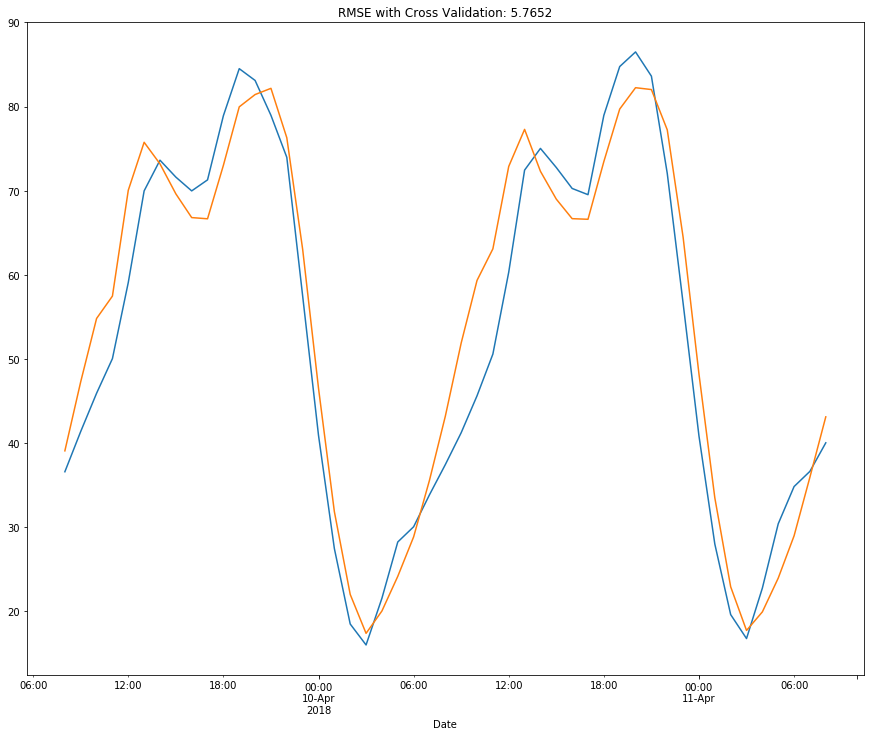

In [11]:
# Forecast Vs. Cross Validation (1/3 from the i/p data)
forecast_start_point = ip_data.index[split_point-1].strftime('%m/%d/%Y %I:%M:%S %p')
forecast_end_point = ip_data.index[len(ip_data)-1].strftime('%m/%d/%Y %I:%M:%S %p')
forecast_data= results.predict(start=forecast_start_point, end=forecast_end_point)
rmse_cv=np.sqrt(sum((forecast_data[1:]-cv)**2)/len(cv))
cv.plot(figsize=(15, 12))
forecast_data[1:].plot(figsize=(15, 12))
plt.title('RMSE with Cross Validation: %.4f'% rmse_cv)
plt.show()

In [12]:
# In[Writing to CSV file]
forecast_data.to_csv("PythonExport.csv", sep=',')

In [ ]:
# In[Writing to excel file]
writer = ExcelWriter('PythonExport1.xlsx')
forecast_data.to_excel(writer)
writer.save()